# Load data and prepare logging

In [1]:
import wandb
wandb.login()

wandb.init(
    project="AlfaFood SSD MobileNet V2",
    config={
        "learning_rate": 1e-4,
        "architecture": "SSD MobileNet V2",
        "dataset": "AlfaFood",
        "epochs": 10,
    }
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mfclabber (mfclabber-itmo-university). Use `wandb login --relogin` to force relogin


In [2]:
from pathlib import Path
import os

data_path = Path("/kaggle/input/alfafood")

def walk_through_dir(dir_path):
    """Walks through dir_path returning file counts of its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

walk_through_dir(data_path)

There are 2 directories and 0 files in '/kaggle/input/alfafood'.
There are 0 directories and 3346 files in '/kaggle/input/alfafood/images'.
There are 0 directories and 3346 files in '/kaggle/input/alfafood/objects'.


[PosixPath('/kaggle/input/alfafood/images/image_0.jpg')]
/kaggle/input/alfafood/images/image_1837.jpg
Random image path: /kaggle/input/alfafood/images/image_1837.jpg
Image height: 480
Image width: 640


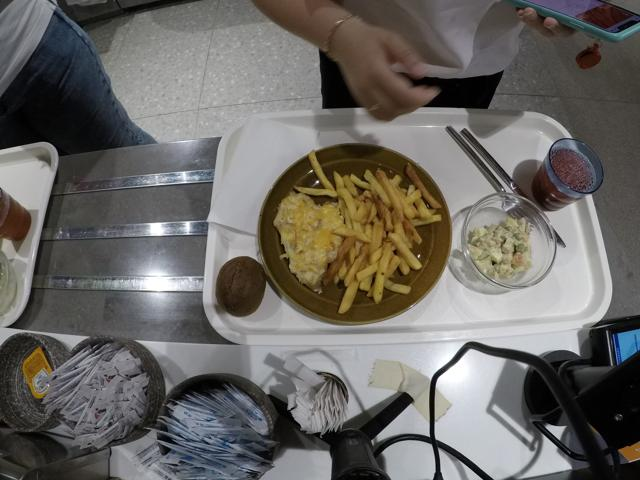

In [3]:
import random
from PIL import Image

image_path_list = sorted(list(data_path.glob("*/*.jpg")))

labels_path_list = sorted(list(data_path.glob("*/*.txt")))
# print(type(image_path_list))
print(image_path_list[:1])

random_image_path = random.choice(image_path_list)
print(random_image_path)

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

In [4]:
from typing import Dict, List, Tuple

def create_objects_from_txt(path: Path) -> Dict[str, List]:
    with open(path, 'r') as file:
        file_content = file.read()

    lines = file_content.splitlines()
    data = dict()
    data["bboxes"], data["labels"] = list(), list()

    for line in lines:
        parts = line.split(' ')
        if len(parts) == 6:
            label = parts[0]
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            data["bboxes"].append([x_center, y_center, width, height])
            data["labels"].append(int(label))
        else:
            print("Invalid data format")
            raise ValueError
    return data
file_path = "/kaggle/input/alfafood/objects/objects_0.txt"
create_objects_from_txt(file_path)

{'bboxes': [[0.0, 0.0, 1.000000013351432e-10, 1.000000013351432e-10]],
 'labels': [0]}

In [5]:
objects = [create_objects_from_txt(file_path) for file_path in labels_path_list]

objects[0]

{'bboxes': [[0.0, 0.0, 1.000000013351432e-10, 1.000000013351432e-10]],
 'labels': [0]}

In [2]:
import os
import cv2
import random
import pathlib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.model_selection import train_test_split

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

from PIL import Image, ImageFile, ImageFont, ImageDraw, ImageEnhance
ImageFile.LOAD_TRUNCATED_IMAGES = True

import copy
import random
from time import time

import warnings
warnings.filterwarnings('ignore')

IMAGE_SHAPE = (640, 480)
FUSED_SHAPE = (320, 320)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class AlfaFoodDataset(Dataset):
    def __init__(self, images: List, objects: List[Dict[str, List]], transform: torchvision.transforms=None) -> None:
        self.images = images
        self.annotations = copy.deepcopy(objects)
        self.transform = transform
        self.num_classes = len(set(i for ob in objects for i in ob['labels']))
        self.list_transforms = np.zeros(shape=(len(self.images),))

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, Tuple[Tuple[int]], Tuple[int]]:
        "Returns one sample of data: image, labels, bboxes"

        image = np.array(Image.open(self.images[index]).convert('RGB'))
        bboxes = self.annotations[index]['bboxes']
        labels = self.annotations[index]['labels']

        if self.transform:
#             print(image.shape)
            transformed = self.transform(image = image, bboxes = bboxes, labels = labels)
            image = np.array(transformed['image']).transpose(1, 2, 0)
            bboxes = transformed['bboxes']
            labels = transformed['labels']

            self.list_transforms[index] = 1
        image = image.transpose(2, 0, 1)
#         print(image.shape)
        target = dict()
        target['boxes'] = torch.as_tensor(bboxes, dtype=torch.float)
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)
        
        if target['boxes'].shape == torch.Size([0]):
            target['boxes'] = torch.Tensor([0, 0, 1e-10, 1e-10]).unsqueeze(dim=0)
        if target['labels'].shape == torch.Size([0]):
            target['labels']= torch.zeros(size=(1, ), dtype=torch.int64)
            
        for box in target['boxes']:
            if box[0] >= box[2]:
                box[0] = box[2]
                box[2] = box[0] + 0.1
                
            if box[1] >= box[3]:
                box[1] = box[3]
                box[3] = box[1] + 0.1
            
        return image, target


    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images)

In [8]:
data = AlfaFoodDataset(image_path_list, objects)

img, target = data[8]
print(img.shape)

(3, 480, 640)


In [3]:
color = list((random.randint(40, 240), random.randint(40, 255), random.randint(60, 255)) for i in range(129))
color

[(78, 155, 247),
 (87, 83, 251),
 (134, 239, 198),
 (131, 164, 154),
 (198, 203, 83),
 (46, 230, 210),
 (224, 98, 235),
 (74, 215, 76),
 (101, 58, 246),
 (52, 169, 114),
 (224, 69, 161),
 (176, 106, 113),
 (134, 102, 232),
 (95, 176, 60),
 (155, 242, 143),
 (215, 239, 155),
 (173, 178, 233),
 (154, 223, 219),
 (49, 184, 71),
 (232, 234, 168),
 (95, 178, 186),
 (104, 52, 142),
 (163, 201, 98),
 (185, 159, 70),
 (94, 167, 201),
 (205, 226, 84),
 (60, 63, 116),
 (86, 73, 113),
 (47, 212, 179),
 (88, 156, 83),
 (80, 206, 81),
 (238, 151, 161),
 (130, 242, 221),
 (59, 155, 253),
 (108, 143, 139),
 (126, 89, 88),
 (81, 149, 156),
 (135, 112, 111),
 (55, 252, 234),
 (238, 45, 72),
 (157, 96, 211),
 (149, 173, 149),
 (213, 121, 151),
 (208, 51, 254),
 (236, 166, 141),
 (202, 133, 179),
 (79, 73, 127),
 (50, 143, 77),
 (137, 221, 226),
 (189, 107, 184),
 (119, 74, 197),
 (239, 170, 60),
 (176, 199, 146),
 (92, 45, 229),
 (44, 49, 91),
 (142, 215, 177),
 (81, 228, 82),
 (49, 107, 233),
 (224, 21

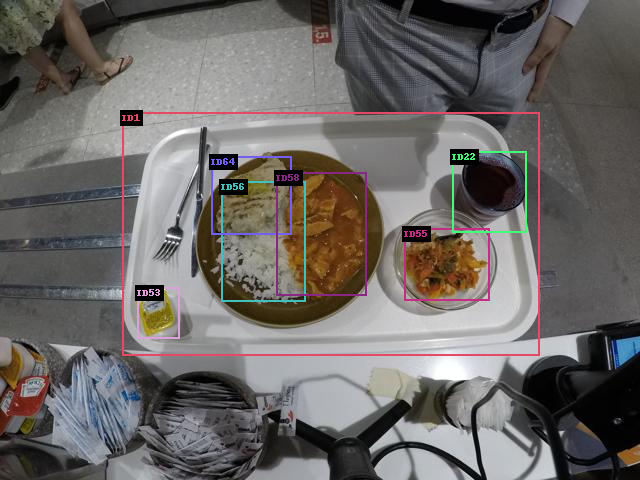

In [9]:
color = list((random.randint(40, 240), random.randint(40, 255), random.randint(60, 255)) for i in range(129))

def objects_threshold_scores(bboxes: torch.Tensor, 
                         labels: torch.Tensor=None, 
                         scores: torch.Tensor=None,
                         threshold_score: float=0.1):
    bboxes_copy = copy.deepcopy(bboxes)
    labels_copy = copy.deepcopy(labels)
    scores_copy = copy.deepcopy(scores)

    bboxes = torch.Tensor([])
    labels, scores = list(), list()
    for i, score in enumerate(scores_copy):
        if score >= threshold_score:
            bboxes = torch.cat((bboxes, bboxes_copy[i].unsqueeze(dim=0)), dim=0)
            labels.append(labels_copy[i])
            scores.append(score)
    
#     bboxes = torch.Tensor(bboxes).unsqueeze(dim=0)
    labels = torch.Tensor(labels)
    scores = torch.Tensor(scores)

    del bboxes_copy, labels_copy, scores_copy

    return bboxes, labels, scores

def show_image_with_objects(image: np.array, 
                            bboxes: torch.Tensor, 
                            labels: torch.Tensor=None, 
                            scores: torch.Tensor=None,
                            threshold_score: float=0.5):

    image = Image.fromarray(image.transpose(1, 2, 0))

#     random.shuffle(color)

    if scores != None:
        bboxes, labels, scores = objects_threshold_scores(bboxes, labels, scores, threshold_score)

    for i in range(len(bboxes)):
        draw = ImageDraw.Draw(image)
        draw.rectangle(bboxes[i].numpy(), outline = color[labels[i].int()], width=2)

        if scores != None:
            bbox = draw.textbbox((bboxes[i][0], bboxes[i][1]), f"ID{int(labels[i])} {scores[i] * 100:.2f}%")
            draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(0, 0, 0))
            draw.text((bboxes[i][0], bboxes[i][1]), f"ID{int(labels[i])} {scores[i] * 100:.2f}%", color[labels[i].int()])
        else:
            bbox = draw.textbbox((bboxes[i][0], bboxes[i][1]), f"ID{int(labels[i])}")
            draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(0, 0, 0))
            draw.text((bboxes[i][0], bboxes[i][1]), f"ID{int(labels[i])}", color[labels[i]])
    return image

img, target = random.choice(data)
show_image_with_objects(img, target['boxes'], target['labels'])

In [10]:
data.num_classes

128

In [11]:
class SSD(torch.nn.Module):
    def __init__(self, num_classes: int=127) -> None:
        super().__init__()

        self.model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=False, pretrained_backbone=False, num_classes=num_classes + 1)
        self.num_classes = num_classes + 1

        for child in list(self.model.children()):
              for param in child.parameters():
                    param.requires_grad = True

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        '''
        For predict bboxes and labels
        '''
        return self.model(X)

    # To calculate the loss function
    def forward(self, images: List[torch.Tensor], annotation: List[Dict[str, torch.Tensor]]) -> Dict[str, int]:
        return self.model(images, annotation)

In [12]:
train_transform = albumentations.Compose(
    [
#         albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
        albumentations.HorizontalFlip(p=0.5),
#         albumentations.Rotate(p=0.5),
#         albumentations.Blur(p=0.1),
#         albumentations.CLAHE(p=0.1),
#         albumentations.ToGray(p=0.1),
        albumentations.MedianBlur(p=0.1),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

test_transform = albumentations.Compose(
    [
#         albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

In [13]:
train_data, test_data = train_test_split(list(zip(image_path_list, objects)), test_size=0.3, shuffle=True, random_state=42)
val_data, data_data = train_test_split(test_data, test_size=0.1, shuffle=True, random_state=42)

train_data = AlfaFoodDataset(images=list(items[0] for items in train_data),
                             objects=list(items[1] for items in train_data),
                             transform=train_transform)

test_data = AlfaFoodDataset(images=list(items[0] for items in test_data),
                            objects=list(items[1] for items in test_data),
                            transform=test_transform )

val_data = AlfaFoodDataset(images=list(items[0] for items in val_data),
                           objects=list(items[1] for items in val_data),
                           transform=test_transform )

In [ ]:
img, target = train_data[8]
print(img.shape)
show_image_with_objects(img, target['boxes'], target['labels'])

(3, 480, 640)


In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=32,
                                               shuffle=True,
                                               num_workers=os.cpu_count(),
                                               collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(dataset=val_data,
                                             batch_size=16,
                                             shuffle=False,
                                             num_workers=os.cpu_count(),
                                             collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                              batch_size=8,
                                              shuffle=False,
                                              num_workers=os.cpu_count(),
                                              collate_fn=collate_fn)

In [ ]:
def train_step(device: torch.device,
               model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               dataloader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module = None,
               scheduler: torch.optim.lr_scheduler = None):

    model.to(device)
    model.train()

    train_loss = 0
    torch.cuda.empty_cache()

    time_epoch_start = time()

    for batch, (images, annotations) in enumerate(dataloader):

        images = [torch.Tensor(image).to(device) for image in images]
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        if criterion == None:
            loss_dict = model(images, annotations)
            loss = sum(loss for loss in loss_dict.values())
        else:
            pass
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        #     print(f"LOSSES: {loss}")
        # print(model(images[0]))

    train_loss = train_loss / len(dataloader)
    time_epoch_end = time() - time_epoch_start

    return train_loss, time_epoch_end



@torch.no_grad()
def validation_step(device: torch.device,
                    model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    criterion: torch.nn.Module = None):
    model.to(device)
    model.eval()

    val_loss = 0
    min_val_loss = 1e6
    torch.cuda.empty_cache()

    time_epoch_start = time()
    with torch.inference_mode():
        for batch, (images, annotations) in enumerate(dataloader):

            images = [torch.Tensor(image).to(device) for image in images]
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

            if criterion == None:
                model.train()
                loss_dict = model(images, annotations)
                # print(loss_dict)
                loss = sum(loss for loss in loss_dict.values())
                model.eval()
            else:
                pass
            val_loss += loss.item()

      # print(f"TESTING MODEL {model.predict(images)}"
      # print(f"LOSSES: {loss}")

    val_loss /= len(dataloader)
    time_epoch_end = time() - time_epoch_start

  # val_loss = validate(epoch)
    if val_loss < min_val_loss:
        print('NEW BEST MODEL!')
        torch.save(model.state_dict(), 'best_model.pth')
        min_val_loss = val_loss
    torch.save(model.state_dict(), 'latest_model.pth')

    return val_loss, time_epoch_end



def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device):
    
    log_output = {
                  'train_loss': [],
                  'val_loss': [],
                  'val_mAP': []
                 }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_train_epoch = train_step(model=model,
                                                   dataloader=train_dataloader,
                                                   optimizer=optimizer,
                                                   device=device)

        print(f"EPOCH: {epoch+1} | TRAIN LOSS: {train_loss} | TRAIN TIME: {train_train_epoch}")

        val_loss, val_time_epoch = validation_step(model=model,
                                                   dataloader=test_dataloader,
                                                   device=device)
        log_output['train_loss'].append(train_loss)
        log_output['val_loss'].append(val_loss)
#         log_output['val_mAP'].append(train_loss)

        print(f"EPOCH: {epoch+1} | VAL LOSS: {val_loss} | VAL TIME: {val_time_epoch}\n")
        
        wandb.log(log_output)

In [25]:
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SSD(data.num_classes)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-2)

train(model, train_dataloader, val_dataloader, optimizer, num_epochs, device)

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 1 | TRAIN LOSS: 10.001194206443992 | TRAIN TIME: 35.16357779502869
NEW BEST MODEL!
EPOCH: 1 | VAL LOSS: 5.78083894744752 | VAL TIME: 13.873239040374756

EPOCH: 2 | TRAIN LOSS: 5.298140422717945 | TRAIN TIME: 33.55203104019165
NEW BEST MODEL!
EPOCH: 2 | VAL LOSS: 5.107398629188538 | VAL TIME: 13.63002061843872

EPOCH: 3 | TRAIN LOSS: 4.79256551330154 | TRAIN TIME: 34.57415437698364
NEW BEST MODEL!
EPOCH: 3 | VAL LOSS: 4.865154928631252 | VAL TIME: 13.678925275802612

EPOCH: 4 | TRAIN LOSS: 4.413896747537561 | TRAIN TIME: 34.501301765441895
NEW BEST MODEL!
EPOCH: 4 | VAL LOSS: 4.539116233114212 | VAL TIME: 13.72672724723816

EPOCH: 5 | TRAIN LOSS: 4.063848199071111 | TRAIN TIME: 32.28105688095093
NEW BEST MODEL!
EPOCH: 5 | VAL LOSS: 4.141858572051639 | VAL TIME: 13.46098518371582

EPOCH: 6 | TRAIN LOSS: 3.7648585970337325 | TRAIN TIME: 34.144134521484375
NEW BEST MODEL!
EPOCH: 6 | VAL LOSS: 3.9410691885721114 | VAL TIME: 13.492006540298462

EPOCH: 7 | TRAIN LOSS: 3.519122578002311

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78448594d5a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [26]:
import pathlib

path_to_weights_model = pathlib.Path("/kaggle/working/best_model.pth")

model.load_state_dict(torch.load(path_to_weights_model, map_location=torch.device('cpu')))

<All keys matched successfully>

(3, 480, 640)
4 4


(-0.5, 639.5, 479.5, -0.5)

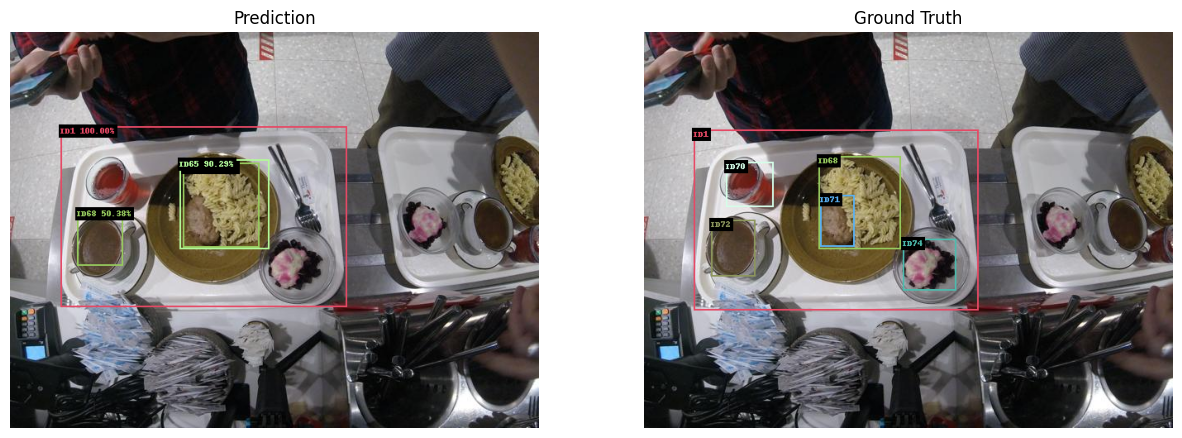

In [76]:
image, target = random.choice(test_data)
print(image.shape)
# images = [torch.Tensor(image.transpose(2, 0, 1)).to(device) for image in images]
# annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

with torch.no_grad():
    model.eval()
    model.to(device)
    outputs = model.predict(torch.Tensor(image).unsqueeze(dim=0).to(device))

bboxes, labels, scores = objects_threshold_scores(outputs[0]['boxes'].to('cpu'), outputs[0]['labels'], outputs[0]['scores'], 0.3)
print(len(labels), len(bboxes))

# pred_boxes, true_boxes = prepare_data(outputs, [target])

# Проверка форматов данных
# print("Pred Boxes:", pred_boxes)
# print("True Boxes:", true_boxes)

# Вычисление mAP50 и mAP50-95
# map50_metric = MAP50(num_classes=len(pred_boxes))
# map50_metric.update(pred_boxes, true_boxes)
# map50 = map50_metric.compute()
# print(f"mAP50: {map50}")

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(show_image_with_objects(image, bboxes, labels, scores, 0.3))

axes[1].imshow(show_image_with_objects(image, target['boxes'], target['labels']))

axes[0].set_title("Prediction")
axes[1].set_title("Ground Truth")

axes[0].axis('off')
axes[1].axis('off')